In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.interpolate import interp1d

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rc('font', size=18)

# cosmologies 
planck2015 = [0.6911, 0.3089, 9.16e-5]
noDE = [0.0,0.3089,9.16e-5]

## Linear evolution

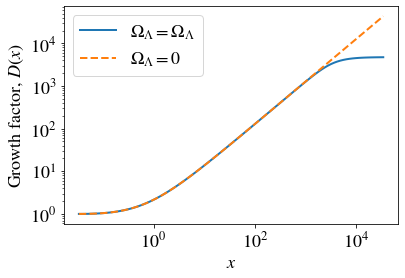

In [2]:
def Omega(a, cosmology):
    rel_lam, rel_mat, rel_rad = cosmology
    return rel_lam + rel_mat*a**(-3) + rel_rad*a**(-4)

def Omega_matter(a, cosmology):
    rel_lam, rel_mat, rel_rad = cosmology
    return rel_mat*a**(-3)

def dOmegada(a, cosmology):
    rel_lam, rel_mat, rel_rad = cosmology
    return -3*rel_mat*a**(-4) - 4*rel_rad*a**(-5)

def sigma(a, cosmology):
    return (0.5*dOmegada(a, cosmology)/Omega(a, cosmology) + 3/a)

def linearODE(y, a, cosmology):
    delta, chi = y
    A = 3/(2*a**2) * Omega_matter(a, cosmology)/Omega(a, cosmology)
    dchi =  A*delta - sigma(a, cosmology)*chi
    return [chi, dchi]

def calculateGrowthFactor(a, cosmology):
    y0 = [1,0]
    psoln = odeint(linearODE, y0, a, args=(cosmology,))
    growthFactor = psoln[:,0]
    
    return growthFactor

a = np.logspace(-5, 1, 100)
x = a/(planck2015[2]/planck2015[1])
plt.loglog(x, calculateGrowthFactor(a,planck2015), label = "$\Omega_{\Lambda} = \Omega_{\Lambda}$", lw = 2)
plt.loglog(x, calculateGrowthFactor(a,noDE), "--", label = "$\Omega_{\Lambda} = 0$", lw = 2)
plt.xlabel("$x$")
plt.ylabel("Growth factor, $D(x)$")
plt.legend();

## Non-linear Evolution

In [3]:
def nonlinearODE(y, x, delta_i, cosmology, tol, verbose = 0):
    Omega_L, Omega_M, Omega_R = cosmology
    
    R, dRdx = y
    
    omega = Omega_L*Omega_R**3/Omega_M**4
    
    A = x*(x+1+omega*x**4)
    B = 0.5*(1-omega*x**3)
    C = -(3/2*x + 1 + 3*omega*x**4)
    
        
    if R > tol:
        d2Rdx2 =  1/A*(-0.5*(1+delta_i)/R**2 + B*R + C*dRdx)
    else:
        d2Rdx2 =  0
        dRdx = 0

    return [dRdx, d2Rdx2]

def find_collapse(x, phis, cosmology, tol):
    xcol = np.zeros(len(phis))
    mask = np.ones(len(phis), dtype=bool)
    for i, phi in enumerate(phis):
        y0 = [1, 0]
        psoln = odeint(nonlinearODE, y0, x, args=(phi, cosmology,  tol, 0))
        R = psoln[:,0];
        
        if sum(R<=tol) > 0:
            R[R<=tol] = 0
            xcol[i] = max(x[R>0])
            if xcol[i] == 0:
                print("Error: xcol[i] == 0\nInfo: delta_i = {:.3}, cosmology = {}".format(phi, cosmology))
        else:
            mask[i] = False
            #print("FALSE!")
    
    return xcol, mask


In [4]:
x = np.logspace(-6, 5, int(1e5))
phis = np.logspace(-3.5, 2, 100)
tol = 1e-5

xcol1, mask1 = find_collapse(x, phis, planck2015, tol)
xcol2, mask2 = find_collapse(x, phis, noDE, tol)
plt.figure(figsize = (7,5))
plt.semilogx(phis[mask1], phis[mask1]*xcol1[mask1], lw = 2, label = "$\Omega_{\Lambda} = \Omega_{\Lambda}$")
plt.semilogx(phis[mask2], phis[mask2]*xcol2[mask2], "--", lw = 2, label = "$\Omega_{\Lambda} = 0$")
plt.ylabel("$C_{col}(\delta_i) = \delta_i x_{col}$")
plt.xlabel("$\delta_i$")
plt.ylim(1.05, 1.2)
plt.legend();

C:\Users\David\anaconda3\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


KeyboardInterrupt: 

## Combining

In [ ]:
def calcThreshDensity(x, deltas, cosmology, tol = 1e-3):
    
    a_eq = cosmology[2]/cosmology[1]
    a = x*a_eq
    
    growthFactor = calculateGrowthFactor(a, cosmology)
    #print("x = [{:.3}, {:.3}]".format(min(x), max(x)))
    D = interp1d(x, growthFactor)
    
    xcol, mask = find_collapse(x, deltas, cosmology, tol)
    #print("xcol = [{:.3}, {:.3}]".format(min(xcol[mask]), max(xcol[mask])))
    
    #print(xcol[mask])
    
    threshDens = deltas[mask]*D(xcol[mask])
    
    return threshDens, xcol[mask], D(xcol[mask]), mask

In [ ]:
x0 = 1/a_eq

xtest = np.logspace(-7, np.log10(x0), int(1e5))
deltas = np.logspace(-3.6, 2, 200)

delta_c1, x1, growth1, mask1 = calcThreshDensity(xtest, deltas, planck2015)
delta_c2, x2, growth2, mask2 = calcThreshDensity(xtest, deltas, noDE)

In [ ]:
plt.figure(figsize = (7,5))
plt.loglog(x1, delta_c1, label = "$\Omega_{\Lambda} = \Omega_{\Lambda}$", lw = 2)
plt.loglog(x2, delta_c2, "--",label = "$\Omega_{\Lambda} = 0$", lw = 2)

oldGrth = 1+3/2*x1
plt.loglog(x1, 1.686*oldGrth/(oldGrth-1), ":",label = r"$1.686\frac{D(x)}{1+D(x)}$", lw = 2)
plt.ylabel("Critical Density, $\delta_c(x)$")
plt.xlabel("$x$")
plt.legend()
plt.show()

plt.figure(figsize = (7,5))
plt.loglog(x1, growth1, label = "$\Omega_{\Lambda} = \Omega_{\Lambda}$", lw = 2)
plt.loglog(x2, growth2, "--",label = "$\Omega_{\Lambda} = 0$", lw = 2)
plt.ylabel("Growth Factor, $D(x)$")
plt.xlabel("$x$")
plt.legend()
plt.show()

plt.figure(figsize = (7,5))
plt.semilogx(deltas[mask1], x1*deltas[mask1], label = "$\Omega_{\Lambda} = \Omega_{\Lambda}$", lw = 2)
plt.semilogx(deltas[mask2], x2*deltas[mask2], "--",label = "$\Omega_{\Lambda} = 0$", lw = 2)
plt.ylabel("$C_{\mathrm{col}} = x_{\mathrm{col}} \delta_{\mathrm{i}}$")
plt.xlabel("$\delta_{\mathrm{i}}$")
plt.ylim([1.05, 1.2])
plt.legend()